## 1. ARIMA原理

ARIMA(Auto Regessive Integrated Moving Average): 自回归整合移动平均，一种经典的时序预测模型，核心理念是可以用序列的滞后项预测未来值。ARIMA属于单变量预测模型，它仅仅使用序列的滞后项作为预测因子，不考虑其它特征。

ARIMA模型通常用下式描述：

$$y_t = c + \beta_1y_{t-1} + \beta_2y_{t-2} + \dots + \beta_py_{t-p} + \theta_1\epsilon_{t-1} + \theta_2\epsilon_{t-2} + \dots + \theta_q\epsilon_{t-q} + \epsilon_t$$

公式的直觉理解：时间序列$y_t$可以表示为自身滞后项和滞后误差项的线性组合。

公式包含两个部分：用滞后项表示的自回归模型(AR)和用滞后误差项表示的移动平均模型(MA).

AR模型：时间序列可以表示为滞后p阶的滞后项的线性组合。

$$y_t = \beta_0 + \beta_1y_{t-1} + \beta_2y_{t-2} + \dots + \beta_py_{t-p} + \epsilon_t$$

MA模型：时间序列可以表示为滞后q阶的滞后误差项的线性组合。

$$y_t = \theta_0 + \epsilon_t + \theta_1\epsilon_{t-1} + \theta_2\epsilon_{t-2} + \dots + \theta_q\epsilon_{t-q}$$

从上面的描述可以看出，ARIMA模型有3个核心参数：p, d, q.

* p: 自回归的阶数
* d: 差分阶数，进行d阶差分令时间序列变成平稳
* q: 移动平均的阶数

ARIMA的要点：

* 如果时间序列没有季节性特征，且不是白噪音，可以用ARIMA建模。
* 如果有季节性特征，则要把这部分内容添加到模型中，称为'SARIMA(Seasonal ARIMA)'.
* 时间序列预测的第一步是把非平稳序列转化为平稳序列。
* ARIMA将滞后项作为回归模型的预测因子，当预测元序列无关且相互独立时，回归模型的系数估计值才是无偏的，所以要求先进行至少d阶差分，令时间序列平稳。如果$y_t$本身是平稳的，d=0.

## 2. 如何确定p, d, q

### 2.1 确定差分阶数d

建立预测模型的第一步是令序列平稳，如果序列非平稳，意味着均值，方差和自相关系数等属性会随着时间发生变化，导致无法预测。

使用ADF检验确定差分阶数和测试序列平稳。

In [3]:
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from pandas import Series

%matplotlib inline

In [4]:
def adf_test(ts: Series) -> None:
    """ADF检验，当p值低于选择的显著性水平如0.05，拒绝存在单位根的原假设，
    认为时间序列是平稳的，相反p值大于阈值认为序列非平稳
    """
    ts.dropna(inplace=True)
    res = adfuller(ts, autolag="AIC")
    print(f"ADF statistic: {res[0]:.3f}")
    print(f"p-value: {res[1]:.3f}")
    print(f"used lags: {res[2]}")

In [5]:
rgdp = pd.read_csv("../quantlab/data/rgdp.csv", parse_dates=["date"], index_col="date")
rgdp["pch"] = round(rgdp["real_gdp"].pct_change(1) * 100, 2)
rgdp["pc1"] = round(rgdp["real_gdp"].pct_change(4) * 100, 2)
rgdp.head()

,real_gdp,pch,pc1
date,,,
1947-01-01,2033.1,NaN,NaN
1947-04-01,2027.6,-0.27,NaN
1947-07-01,2023.5,-0.20,NaN
1947-10-01,2055.1,1.56,NaN
1948-01-01,2086.0,1.50,2.6


In [6]:
print("\noriginal series")
print("="*30)
adf_test(rgdp["real_gdp"])
print("="*30)

print("\nfirst difference")
print("="*30)
adf_test(rgdp["real_gdp"].diff())
print("="*30)

print("\nsecond difference")
print("="*30)
adf_test(rgdp["real_gdp"].diff().diff())
print("="*30)

print("\nthird difference")
print("="*30)
adf_test(rgdp["real_gdp"].diff().diff().diff())
print("="*30)


original series
ADF statistic: 2.216
p-value: 0.999
used lags: 2

first difference
ADF statistic: -7.369
p-value: 0.000
used lags: 1

second difference
ADF statistic: -6.941
p-value: 0.000
used lags: 12

third difference
ADF statistic: -7.850
p-value: 0.000
used lags: 14


上面的例子表明，一阶差分就可以令序列平稳，那么不需要进行二阶以上的差分，d=1.

作为经验法则，经济时间序列如GDP，股票收盘价等，通常一阶差分已经足够。

### 2.2 确定自回归阶数p

AR(p)模型一般表示为：$y_t = \beta_0 + \beta_1y_{t-1} + \beta_2y_{t-2} + \dots + \beta_py_{t-p} + \epsilon_t$

系数$\beta_{t-p}$就是滞后p阶的偏自相关系数(PACF)，PACF(p)度量时间序列$y_t$和滞后p阶的序列$y_{t-p}$的相关性，剔除$y_{t-1}, \dots, y_{t-p+1}$这些中间滞后项的影响。

所以可以根据PACF确定自回归阶数p。

先计算尽可能多滞后项的PACF，然后进行显著性检验，如果PACF(k)显著异于零，但PACF(k+1)显著不异于零，得到结论$p = k$.

In [7]:
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

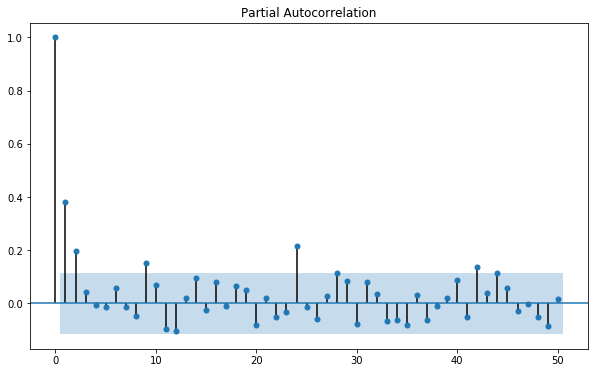

In [8]:
# 继续以美国实际GDP为例，上面已经说明一阶差分后的序列是平稳的
# 调用plot_pacf()时保证序列没有缺失值，否则无法计算
fig, ax = plt.subplots(figsize=(10, 6))
ax = plot_pacf(rgdp["real_gdp"].diff().dropna(), ax=ax, lags=50)

图中淡蓝色区域是显著性区间，如果PACF(k)落在区间内，认为不显著异于零。可以看到PACF(1)和PACF(2)在区间外，所以自回归阶数p = 2.

### 2.3 确定移动平均阶数q

MA(q)模型一般表示为：$y_t = \theta_0 + \epsilon_t + \theta_1\epsilon_{t-1} + \theta_2\epsilon_{t-2} + \dots + \theta_q\epsilon_{t-q}$，$\epsilon_{t-q}$是滞后$(t-q)$阶的滞后误差项。

系数$\theta_{t-q}$就是滞后q阶的自相关系数(ACF)，可以根据ACF确定移动平均阶数q。

先计算尽可能多滞后项的ACF，然后进行显著性检验，如果ACF(k)显著异于零，但ACF(k+1)显著不异于零，得到结论$q = k$.

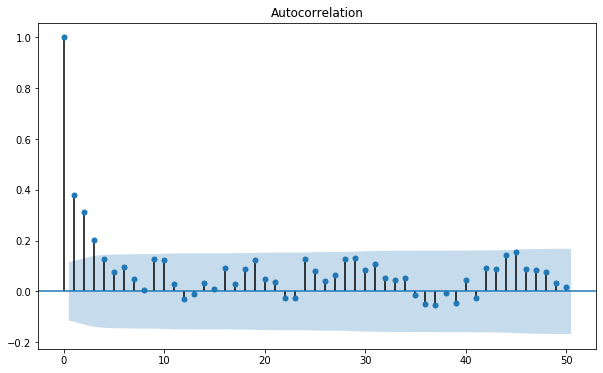

In [9]:
# 继续以美国实际GDP为例，上面已经说明一阶差分后的序列是平稳的
# 调用plot_acf()时保证序列没有缺失值，否则无法计算
fig, ax = plt.subplots(figsize=(10, 6))
ax = plot_acf(rgdp["real_gdp"].diff().dropna(), ax=ax, lags=50)

ACF图和PACF图的解读规则一样，如果ACF(k)处于蓝色区域内，认为不显著异于零。这里可以认为q = 3.

## 3. 实现ARIMA

确定了核心参数(p,d,q)后，就可以建立ARIMA模型，statsmodels提供了接口。

In [10]:
from statsmodels.tsa.arima_model import ARIMA

In [11]:
# 创建ARIMA模型对象，预测美国实际GDP
model = ARIMA(rgdp.real_gdp, order=(2, 1, 3), freq="QS-OCT")

# 调用fit方法拟合数据，语法跟sklearn基本一致
results = model.fit()

查看模型结果。

In [12]:
print(results.summary())

                             ARIMA Model Results                              
Dep. Variable:             D.real_gdp   No. Observations:                  292
Model:                 ARIMA(2, 1, 3)   Log Likelihood               -1625.686
Method:                       css-mle   S.D. of innovations             63.302
Date:                Fri, 26 Jun 2020   AIC                           3265.373
Time:                        09:38:09   BIC                           3291.110
Sample:                    04-01-1947   HQIC                          3275.682
                         - 01-01-2020                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const               56.6896      7.856      7.216      0.000      41.293      72.087
ar.L1.D.real_gdp    -0.3420      0.137     -2.491      0.013      -0.611      -0.073
ar.L2.D.real_gdp     0.6373 

二阶和三阶移动平均的系数估计值显著不异于零(p > 0.05)，考虑将MA(q)的滞后项调整为1，看是否能提高拟合优度。

In [13]:
model2 = ARIMA(rgdp.real_gdp, order=(1,1,1), freq="QS-OCT")
results2 = model2.fit()
print(results2.summary())

                             ARIMA Model Results                              
Dep. Variable:             D.real_gdp   No. Observations:                  292
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -1626.624
Method:                       css-mle   S.D. of innovations             63.515
Date:                Fri, 26 Jun 2020   AIC                           3261.249
Time:                        09:38:09   BIC                           3275.956
Sample:                    04-01-1947   HQIC                          3267.140
                         - 01-01-2020                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const               56.5739      8.237      6.868      0.000      40.429      72.719
ar.L1.D.real_gdp     0.7282      0.082      8.853      0.000       0.567       0.889
ma.L1.D.real_gdp    -0.3944 

如果仅仅把q调整为1，其余系数估计值都显著不异于零，最终选择(p=1,d=1,q=1)，所有系数估计值都能通过显著性检验。与初始模型相比，AIC明显下降，调整后的模型的确更优。

接下来我们查看模型残差，如果残差是白噪音，证明模型捕捉了信号，否则模型有改善的空间。

回顾白噪音的定义：白噪音是随机时间序列，具有零均值，固定方差和序列无关的特点，理论上可以服从任何分布。

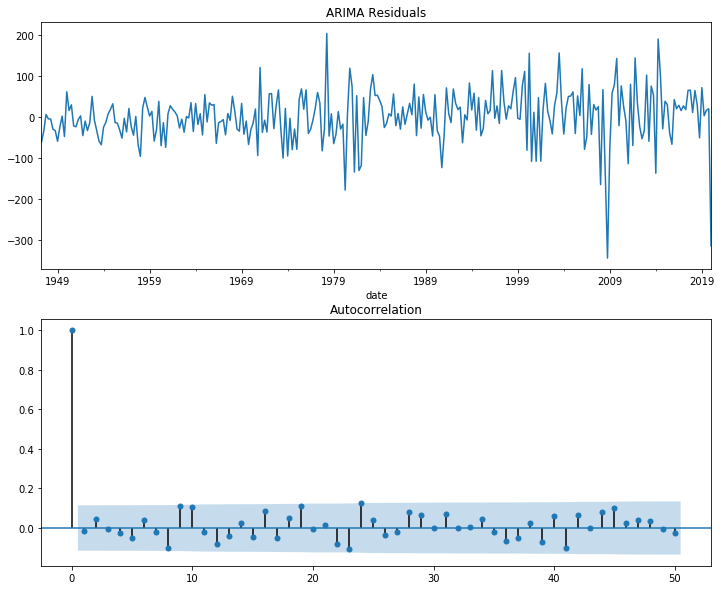

In [14]:
# 提取模型残差
resid = results2.resid

fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(12, 10))
ax1 = resid.plot(ax=ax[0])
ax1.set_title("ARIMA Residuals")
ax2 = plot_acf(resid, ax=ax[1], lags=50)

残差图显示均值接近零，但方差随着时间推移逐渐变大。自相关图显示残差的确是序列无关的。

## 4. 选择最优模型

1. 拆分数据集，train-test split, 保持时间顺序的完整性。
2. 选择不同的p,d,q组合：
    + 2.1 在训练集拟合数据，记录AIC(拟合优度)。
    + 2.2 在测试集评估预测精度。
3. 选择拟合优度最好或预测精度最高的模型。

In [15]:
def evaluate_accuracy(forecast, actual):
    """计算常用的精度评估指标"""
    # 平均绝对误差 MAE
    mae = np.mean(np.abs(forecast - actual))
    # 平均绝对百分比误差 MAPE
    mape = np.mean(np.abs(forecast - actual) / np.abs(actual))
    # 均方误差 MSE
    mse = np.mean((forecast - actual) ** 2)
    # 均方根误差 RMSE
    rmse = np.sqrt(mse)
    # 实际值和预测值的相关系数
    corr = np.corrcoef(forecast, actual)[0, 1]
    
    return {
        "mae": mae,
        "mape": mape,
        "mse": mse,
        "rmse": rmse,
        "corr": corr
    }

In [16]:
# train-test split，大概按80:20划分，即训练集占前80%数据，检验集占后面20%
split_point = int(len(rgdp) * 0.8)
train = rgdp.iloc[:split_point]
test = rgdp.iloc[split_point:]

# 参数扫描区间
p_range = np.arange(0, 3)
q_range = np.arange(0, 3)
d = 1  # 上面分析已经表明，进行一阶差分足以令序列平稳

# 遍历所有参数组合，建立模型
results = []
for p in p_range:
    for q in q_range:
        try:
            # 建立模型，拟合数据
            t0 = time.time()
            model = ARIMA(train.real_gdp, order=(p,d,q), freq="QS-OCT")
            fitted = model.fit()
            aic = round(fitted.aic, 2)
            # 样本外预测
            fc, se, conf = fitted.forecast(steps=len(test), alpha=0.05)
            # 评估预测精度
            metrics = evaluate_accuracy(fc, test.real_gdp)
            metrics.update({
                "params": str((p, d, q)),
                "aic": aic
            })
            # 记录结果
            results.append(metrics)
            elapsed = time.time() - t0
            print(f"{str((p,d,q))}: AIC={fitted.aic:.2f}, time={elapsed:.3f} seconds")
        except Exception as e:
            pass
            
results_df = pd.DataFrame.from_records(results)

(0, 1, 0): AIC=2574.71, time=0.048 seconds
(0, 1, 1): AIC=2548.48, time=0.047 seconds
(0, 1, 2): AIC=2528.22, time=0.051 seconds
(1, 1, 0): AIC=2531.31, time=0.033 seconds
(1, 1, 1): AIC=2520.76, time=0.072 seconds
(1, 1, 2): AIC=2522.09, time=0.110 seconds
(2, 1, 0): AIC=2519.11, time=0.056 seconds
(2, 1, 1): AIC=2520.94, time=0.087 seconds


In [17]:
results_df.sort_values("aic", ascending=True)

,mae,mape,mse,rmse,corr,params,aic
6,405.156986,0.023689,239838.235338,489.732820,0.957433,"(2, 1, 0)",2519.11
4,395.195208,0.023280,227269.415358,476.727821,0.954954,"(1, 1, 1)",2520.76
7,409.113057,0.023874,245643.261052,495.624113,0.957881,"(2, 1, 1)",2520.94
5,401.739226,0.023533,235302.469811,485.079859,0.956920,"(1, 1, 2)",2522.09
2,419.040722,0.024367,260909.769510,510.793275,0.958438,"(0, 1, 2)",2528.22
3,418.259046,0.024330,259523.277394,509.434272,0.958361,"(1, 1, 0)",2531.31
1,420.423309,0.024443,262548.132504,512.394509,0.958403,"(0, 1, 1)",2548.48
0,418.895774,0.024364,259986.621187,509.888832,0.958403,"(0, 1, 0)",2574.71


In [18]:
results_df.sort_values("mape", ascending=True)

,mae,mape,mse,rmse,corr,params,aic
4,395.195208,0.023280,227269.415358,476.727821,0.954954,"(1, 1, 1)",2520.76
5,401.739226,0.023533,235302.469811,485.079859,0.956920,"(1, 1, 2)",2522.09
6,405.156986,0.023689,239838.235338,489.732820,0.957433,"(2, 1, 0)",2519.11
7,409.113057,0.023874,245643.261052,495.624113,0.957881,"(2, 1, 1)",2520.94
3,418.259046,0.024330,259523.277394,509.434272,0.958361,"(1, 1, 0)",2531.31
0,418.895774,0.024364,259986.621187,509.888832,0.958403,"(0, 1, 0)",2574.71
2,419.040722,0.024367,260909.769510,510.793275,0.958438,"(0, 1, 2)",2528.22
1,420.423309,0.024443,262548.132504,512.394509,0.958403,"(0, 1, 1)",2548.48


从样本内拟合优度来看，(2,1,0)的AIC最小，样本外预测精度最高是(1,1,1)，而且AIC与(2,1,0)几乎相同，所以最优模型选择ARIMA(1,1,1).

接下来最优模型的预测值和实际值的关系。

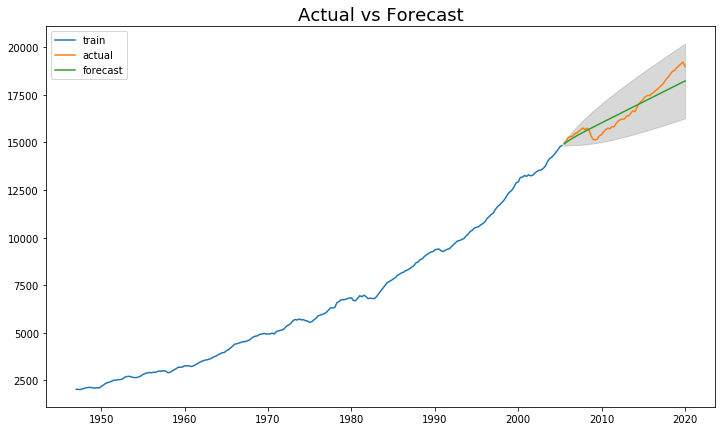

In [19]:
# 最优模型，预测
model = ARIMA(train.real_gdp, order=(1,1,1), freq="QS-OCT")
fitted = model.fit()
fc, se, conf = fitted.forecast(steps=len(test), alpha=0.05)

# 将点预测值和置信区间放到数据框
fc_df = pd.DataFrame({
    "forecast": fc,
    "lower": conf[:,0],
    "upper": conf[:,1]
}, index=test.index)

# 可视化
fig, ax = plt.subplots(figsize=(12, 7))
ax.plot(train.index, train.real_gdp, label="train")
ax.plot(test.index, test.real_gdp, label="actual")
ax.plot(fc_df.index, fc_df.forecast, label="forecast")
ax.fill_between(fc_df.index, fc_df.lower, fc_df.upper, color="grey", alpha=0.3)
ax.set_title("Actual vs Forecast", fontsize=18)
ax.legend()

## 5. 自动拟合ARIMA

拟合ARIMA模型需要先确定参数(p,d,q)，借助pmdarima.auto_arima()函数，可以自动选择最优的参数组合。auto_arima()采取逐步回归的做法，遍历多个参数组合，选择AIC最小的模型。

In [20]:
from pmdarima import auto_arima

In [21]:
model = auto_arima(
    y=train.real_gdp,
    start_p=1,  # AR(p)开始阶数
    d=None,  # 不指定差分阶数，让模型决定
    start_q=1,  # MA(q)开始阶数
    max_p=3,  # AR(p)最高阶数
    max_q=3,  # MA(q)最高阶数
    max_d=2,  # 最高差分阶数
    m=1,  # 季节性差分，m=1意味着无季节性
    seasonal=False,  # 无季节性
    stationary=False,  # 原始时间序列是否平稳
    test="adf",  # 使用ADF检验决定序列是否平稳和差分阶数
    stepwise=True,  # 使用stepwise算法寻找最优参数组合
    trace=True  # 打印每次拟合的信息
)

Performing stepwise search to minimize aic
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=2520.892, BIC=2534.696, Time=0.134 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=2574.709, BIC=2581.611, Time=0.014 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=2531.414, BIC=2541.767, Time=0.052 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=2548.535, BIC=2558.888, Time=0.083 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=False]; AIC=2713.990, BIC=2717.441, Time=0.008 seconds
Fit ARIMA(2,1,1)x(0,0,0,0) [intercept=True]; AIC=2521.077, BIC=2538.332, Time=0.161 seconds
Fit ARIMA(1,1,2)x(0,0,0,0) [intercept=True]; AIC=2522.224, BIC=2539.480, Time=0.171 seconds
Fit ARIMA(0,1,2)x(0,0,0,0) [intercept=True]; AIC=2528.325, BIC=2542.129, Time=0.100 seconds
Fit ARIMA(2,1,0)x(0,0,0,0) [intercept=True]; AIC=2519.243, BIC=2533.047, Time=0.092 seconds
Fit ARIMA(3,1,0)x(0,0,0,0) [intercept=True]; AIC=2521.209, BIC=2538.464, Time=0.142 seconds
Fit ARIMA(3,1,1)x(0,0,0,0) [intercep

In [22]:
print(model.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  234
Model:               SARIMAX(2, 1, 0)   Log Likelihood               -1255.622
Date:                Fri, 26 Jun 2020   AIC                           2519.243
Time:                        09:38:12   BIC                           2533.047
Sample:                             0   HQIC                          2524.810
                                - 234                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     23.9579      4.725      5.071      0.000      14.697      33.218
ar.L1          0.3180      0.059      5.355      0.000       0.202       0.434
ar.L2          0.2444      0.053      4.608      0.0

依据AIC最小的原则，最优模型是ARIMA(2,1,0)，这跟上一部分的结果相同。

## 6. 模型诊断

模型诊断是建立时序预测模型不可或缺的一部分，重点在于判断残差是否为白噪音。白噪音是随机时间序列，具有零均值，有限方差和序列无关等特点。

时间序列往往被认为是信号和白噪音的集合：$y_t = s_t + \epsilon_t$，其中$s_t$代表潜在信号，是可以被建模的部分，而$\epsilon_t$是白噪音，代表不可预测的随机冲击。如果模型残差是白噪音，意味着模型捕捉了信号，如果残差仍然是有规律的，意味着模型有改善的空间。

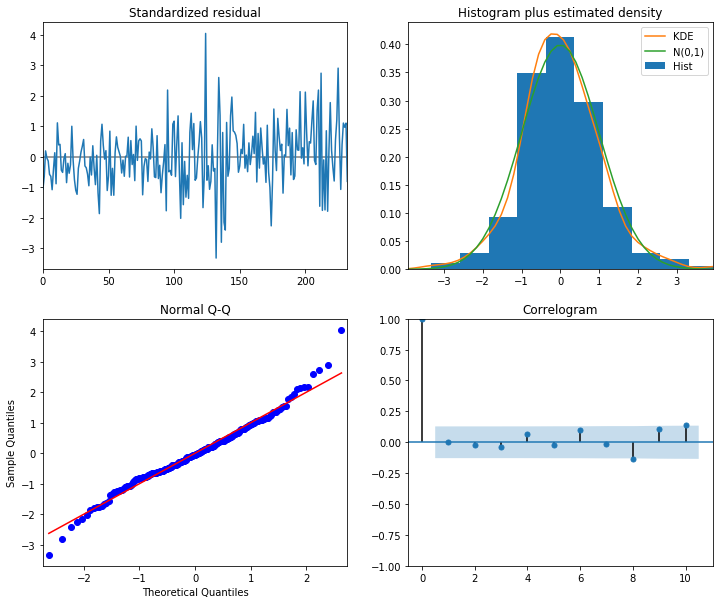

In [23]:
ax = model.plot_diagnostics(figsize=(12, 10))

如何解读：

1. 左上：标准化残差的趋势图，是否具有零均值和固定方差。
2. 右上：标准化残差的直方图，是否接近正态分布。
3. 左下：分位图，残差是否服从正态分布。
4. 右下：自相关图，残差是否序列无关。

QQ plot: 分位图，Q代表quantile，即分位数。分位图将两组数据的分位数相对比，看它们是否来源于相同的分布，通常用于测试某组数据是否服从理论分布，例如回归模型中最常见的正态分布。分位图的X轴是理论分布的分位数，Y轴是检测数据的分位数，如果点落在$y=x$这条45度线，认为两者是相同分布。

分位图百科：[Statistics Howto](https://www.statisticshowto.com/q-q-plots/)

## 7. SARIMA

ARIMA假设时间序列无季节性，如果时序有明显的季节性特征，应该添加到模型中，简称SARIMA(p,d,q)(P,D,Q)m.

与ARIMA相比，SARIMA新增四个参数：

* P: 季节性自回归阶数
* D: 季节性差分阶数
* Q: 季节性移动平均阶数
* m: 季节性周期，例如月度数据是12，季度数据是4

一般情况下会使用自动搜索技术，寻找最优的参数组合。

In [24]:
# 加载drugSales数据，与实际GDP不同，该销售数据有明显的季节性
sales = pd.read_csv("data/drug_sales.csv", parse_dates=["date"], index_col="date")
sales = sales.assign(year=lambda x: x.index.year, month=lambda x: x.index.month)
sales.tail()

,value,year,month
date,,,
2008-02-01,21.654285,2008,2
2008-03-01,18.264945,2008,3
2008-04-01,23.107677,2008,4
2008-05-01,22.912510,2008,5
2008-06-01,19.431740,2008,6


如何识别时间序列是否有季节性？

- 可视化
    - 趋势图，有季节性特征的时间序列会出现重复性的锯齿形波动。
    - 箱线图，按照某个时间周期（如月，季度等）分类汇总，看是否有显著的规律。
- 自相关系数

Text(0.5, 1.0, 'Drug Sales')

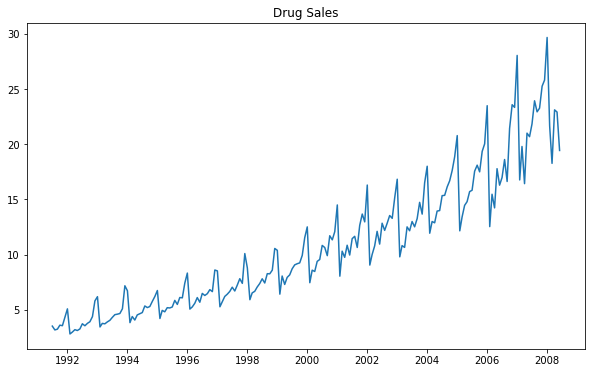

In [25]:
# 趋势图
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(sales.index, sales.value)
ax.set_title("Drug Sales")

Text(0.5, 1.0, 'Drug Sales by Year')

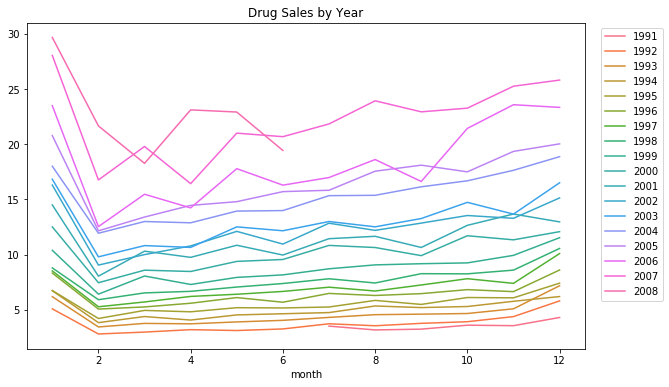

In [26]:
# 将wide-format转化为long-format，year作为列
sales_by_year = sales.pivot(index="month", columns="year", values="value")

fig, ax = plt.subplots(figsize=(10, 6))
# dashes=False, sns默认用不同的虚线表示不同的列变量，但最多只支持6种虚线
sns.lineplot(data=sales_by_year, dashes=False, ax=ax)
# 当图例过大时，可以将图例放到坐标之外，设置bbox_to_anchor=(x, y)
# (x,y)表示图例右上角的坐标
ax.legend(loc="best", bbox_to_anchor=(1.02, 1))
ax.set_title("Drug Sales by Year")

Text(0.5, 1.0, 'Boxplot for drug sales')

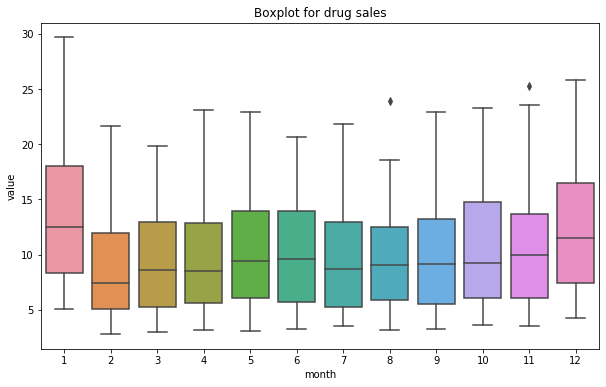

In [27]:
# 箱线图
fig, ax = plt.subplots(figsize=(10, 6))
ax = sns.boxplot("month", "value", data=sales, ax=ax)
ax.set_title("Boxplot for drug sales")

从上面的几幅图看出，药物销量有明显的季节性，一月份的销量最高，二月份显著萎缩。

在实现ARIMA时，先要确定核心参数(p,d,q)，构建SARIMA模型也要先确定参数，这里我们使用auto_arima函数自动搜索，寻找令AIC最小的模型。

In [28]:
# 拆分训练集和检验集
train_size = 0.8
train = sales.iloc[:int(len(sales) * train_size)]
test = sales.iloc[int(len(sales) * train_size):]

# 创建模型，拟合数据
model = auto_arima(
    y=train.value,
    start_p=1,  # 自回归模型阶数
    d=None,  # 差分阶数，由模型决定
    start_q=1,  # 移动平均阶数
    max_p=3,  # 自回归模型最大阶数
    max_d=2,  # 最大差分阶数
    max_q=3,  # 移动平均最大阶数
    start_P=1,  # 季节性自回归模型阶数
    D=None,  # 季节性差分阶数
    start_Q=1,  # 季节性移动平均阶数
    m=12,  # 季节性的周期，月数据一般设置为12
    seasonal=True,  # 包含季节性
    stationary=False,  # 原始时间序列非平稳
    test="adf",  # 根据ADF检验决定差分阶数
    stepwise=True,  # 使用stepwise算法寻找最优参数
    trace=True,  # 打印每次拟合的信息
    suppress_warnings=True
)

# 模型结果
print(model.summary())

Performing stepwise search to minimize aic
Fit ARIMA(1,1,1)x(1,1,1,12) [intercept=True]; AIC=245.200, BIC=263.263, Time=0.583 seconds
Fit ARIMA(0,1,0)x(0,1,0,12) [intercept=True]; AIC=336.666, BIC=342.688, Time=0.082 seconds
Fit ARIMA(1,1,0)x(1,1,0,12) [intercept=True]; AIC=280.386, BIC=292.429, Time=0.165 seconds
Fit ARIMA(0,1,1)x(0,1,1,12) [intercept=True]; AIC=249.767, BIC=261.809, Time=0.348 seconds
Fit ARIMA(0,1,0)x(0,1,0,12) [intercept=False]; AIC=334.748, BIC=337.759, Time=0.017 seconds
Fit ARIMA(1,1,1)x(0,1,1,12) [intercept=True]; AIC=246.233, BIC=261.286, Time=0.310 seconds
Fit ARIMA(1,1,1)x(1,1,0,12) [intercept=True]; AIC=249.610, BIC=264.664, Time=0.263 seconds
Fit ARIMA(1,1,1)x(2,1,1,12) [intercept=True]; AIC=244.472, BIC=265.547, Time=0.930 seconds
Fit ARIMA(1,1,1)x(2,1,0,12) [intercept=True]; AIC=243.856, BIC=261.920, Time=0.555 seconds
Fit ARIMA(0,1,1)x(2,1,0,12) [intercept=True]; AIC=247.521, BIC=262.575, Time=0.436 seconds
Fit ARIMA(1,1,0)x(2,1,0,12) [intercept=True]; 

最优模型是SARIMA(0,1,2)(2, 1, 0, 12)，AIC=243.72，所有系数都统计显著。接下来在测试集测试预测能力。

{'mae': 1.8596903995318361, 'mape': 0.10786706723168803, 'mse': 5.324492195567793, 'rmse': 2.3074861203413106, 'corr': 0.9254418180690182}


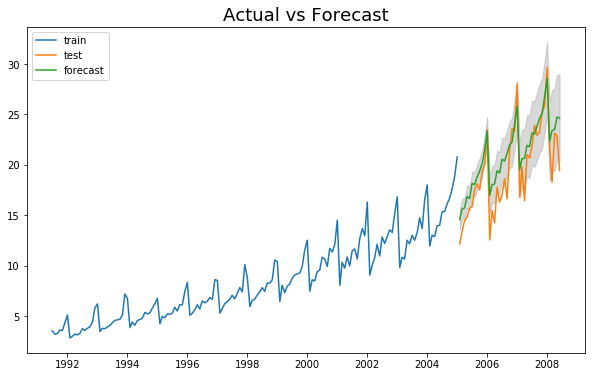

In [29]:
# 样本外预测
fc, conf = model.predict(len(test), return_conf_int=True, alpha=0.05)
fc_df = pd.DataFrame({
    "forecast": fc,
    "lower": conf[:,0],
    "upper": conf[:,1]
}, index=test.index)

# 评估预测精度
metrics = evaluate_accuracy(fc, test.value)
print(metrics)

# 可视化预测结果
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(train.index, train.value, label="train")
ax.plot(test.index, test.value, label="test")
ax.plot(fc_df.index, fc_df.forecast, label="forecast")
ax.fill_between(fc_df.index, fc_df.lower, fc_df.upper, color="grey", alpha=0.3)
ax.set_title("Actual vs Forecast", fontsize=18)
ax.legend()

上面的模型虽然成功捕捉了季节性特征，但预测精度不高，平均绝对百分比误差(MAPE)达到10.8%，从商业角度考量，模型还有待改进。